In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [26]:
from pathlib import Path
from typing import List, Tuple, Union, Dict, Optional
import tensorflow as tf

import random
import numpy as np
from sklearn.preprocessing import LabelEncoder

from enum import Enum, auto
import albumentations as A
import cv2

class Stages(Enum):
    TRAIN = auto()
    VALID = auto()
    INFER = auto()


def get_transforms(size: int, stage: Stages) -> A.Compose:
    transforms_list = [
        A.CLAHE(always_apply=True),
    ]

    if stage is Stages.TRAIN:
        transforms_list += [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Transpose(p=0.5),
            A.RandomRotate90(p=0.5),
            A.CropNonEmptyMaskIfExists(size, size, always_apply=True),
        ]
    else:
        transforms_list += [
            A.LongestMaxSize(size, always_apply=True),
            A.PadIfNeeded(size, size, always_apply=True),
        ]
    return A.Compose(transforms_list)

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

SEED = 42

INPUT_IMAGE_SIZE = 320
INFER_IMAGE_SIZE = 1632
prefix = '../'
TRAIN_FOLDER = f"{prefix}datasets/train-handpicked"
VALID_FOLDER = f"{prefix}datasets/valid-handpicked"
INFER_FOLDER = f"{prefix}datasets/infer"

seed_everything(SEED)

import matplotlib.pylab as plt
from PIL import Image

def t2i(tensor):
    return Image.fromarray(tensor.numpy().astype(np.uint8))

def tensor_to_image(tensor):
    return (tensor['image']).astype(np.uint8)

def tensor_to_mask(tensor):
    return 255-np.clip((tensor['mask']*255)[:,:], 0, 255).astype(np.uint8)

def overlay_image_and_mask(tensor, color=(255,0,0)):
    image = Image.fromarray(tensor_to_image(tensor))
    mask = Image.fromarray(tensor_to_mask(tensor))
    return np.asarray(Image.composite(image, Image.new('RGB', image.size, color), mask.convert('L')))

class StageDataset:
    def __init__(
        self,
        folder: str,
        filenames: List[str],
        size: Union[Tuple[int, int], int] = INPUT_IMAGE_SIZE,
        transform: Optional[A.Compose] = None,
        train: bool = True
    ):
        if isinstance(size, int):
            size = (size, size)

        self.size = size
        self.folder = folder
        self.filenames = filenames
        self.train = train
        
        self.transform = transform
       
    @staticmethod
    def decode_img(filename: str, size: Tuple[int,int], channels: int, interpolation='bicubic', antialias=True):
        img = tf.io.read_file(filename)
        img = tf.io.decode_image(img, channels=channels)
        if size is not None:
            img = tf.image.resize(img, size, method=interpolation, antialias=antialias)
        img = tf.clip_by_value(img, 0, 255)
        img = tf.cast(img, dtype=tf.uint8)
        return img
    
    @staticmethod
    def imread(filename: str, size: Tuple[int,int]) -> tf.Tensor:
        return StageDataset.decode_img(filename, size, 3).numpy()
    
    @staticmethod
    def maskread(filename: str, size: Tuple[int,int]) -> tf.Tensor:
        mask = StageDataset.decode_img(filename, size, 1, interpolation='nearest', antialias=False)
        mask = tf.cast(mask, tf.float32) / 255.
        mask = tf.squeeze(tf.cast(mask, tf.uint8))
        return mask.numpy()

    def __getitem__(self, index) -> Dict[str, tf.Tensor]:
        args1 = (f"{self.folder}/images/{self.filenames[index]}", self.size)
        args2 = (f"{self.folder}/masks/{self.filenames[index]}", self.size)
        output = {'image': StageDataset.imread(*args1)}
        if self.train:
            mask = StageDataset.maskread(*args2)
            output['mask'] = mask
            
        if self.transform:
            output = self.transform(**output)
            
        if self.train:
            output['mask_onehot'] = tf.one_hot(output['mask'], depth=2).numpy()
            
        return output

    def __len__(self):
        return len(self.filenames)
    
def get_data_generator(stage_data: StageDataset, preprocessing, mask_key='mask_onehot'):
    for item in iter(stage_data):
        image = preprocessing(item['image'])
        mask = item[mask_key]
        yield image, mask
    
def glob_filenames(folder: str, ext: str):
    return [x.name for x in Path(folder).glob(f"*.{ext}")]


##prepare data
def get_train_data(stage_folder: str, transform: Optional[A.Compose]=None,):
    images = set(glob_filenames(f"{stage_folder}/images", "png"))
    masks = set(glob_filenames(f"{stage_folder}/masks", "png"))
    images_w_masks = sorted(list(images.intersection(masks)), key=lambda x: int(x.split('.')[0]))
    stage_ds = StageDataset(stage_folder, images_w_masks, None, transform=transform)
    return stage_ds

def get_test_data(stage_folder: str, transform: Optional[A.Compose]=None,):
    images = set(glob_filenames(f"{stage_folder}/images", "png"))
    images = sorted(list(images), key=lambda x: int(x.split('.')[0]))
    return StageDataset(stage_folder, images, None, transform=transform, train=False)

def get_stage_data(stage_folder: str, transform: Optional[A.Compose]=None, train: bool = True):
    if train: stage = get_train_data(stage_folder, transform)
    else: stage = get_test_data(stage_folder, transform)
    
    print(len(stage))
    return stage

train_transform = get_transforms(INPUT_IMAGE_SIZE, Stages.TRAIN)
valid_transform = get_transforms(INFER_IMAGE_SIZE, Stages.VALID)

train_data = get_stage_data(TRAIN_FOLDER, train_transform)
valid_data = get_stage_data(VALID_FOLDER, valid_transform)
infer_data = get_stage_data(INFER_FOLDER, valid_transform, train=False)

61
177
301


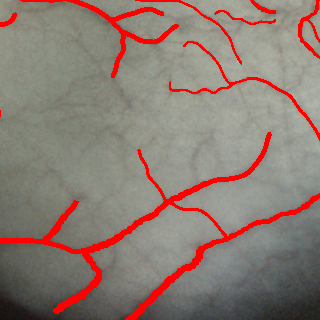

In [27]:
Image.fromarray(overlay_image_and_mask(train_data[np.random.randint(len(train_data))]))

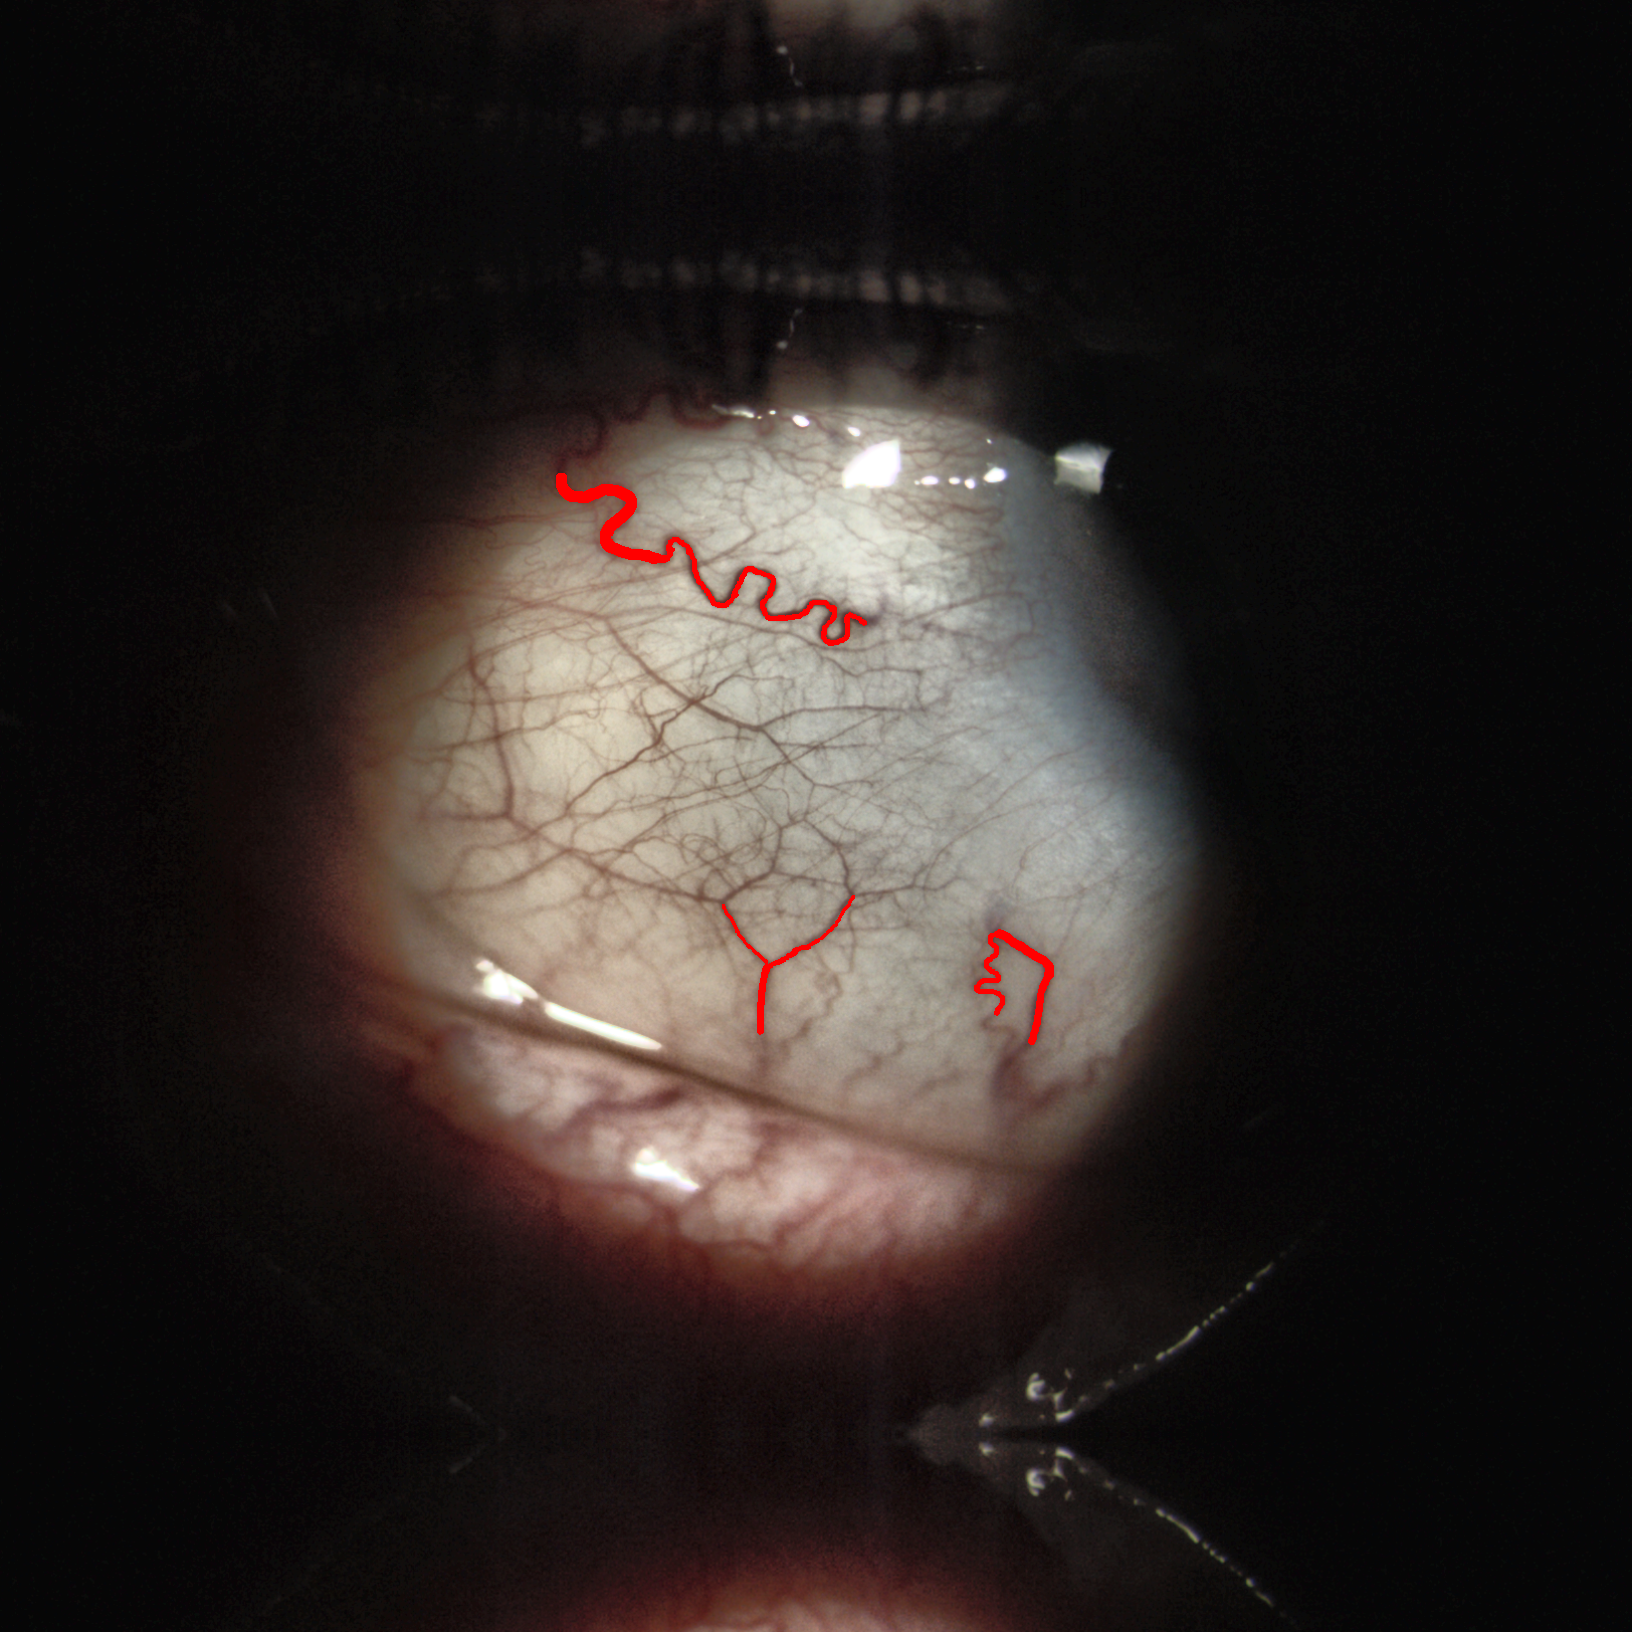

In [28]:
Image.fromarray(overlay_image_and_mask(valid_data[np.random.randint(len(valid_data))]))

# Model selection

In [29]:
import segmentation_models as sm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger, ReduceLROnPlateau

sm.set_framework('tf.keras')

N_CLASSES=2
ACTIVATION='softmax'

LR = 1e-3
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.8, .2])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]



In [30]:
NUM_WORKERS = tf.data.AUTOTUNE
PREFETCH_BUFFER = tf.data.AUTOTUNE
TRAIN_BATCH_SIZE = 4
INFER_BATCH_SIZE = 1

train_dataset = tf.data.Dataset.from_generator(
    lambda: get_data_generator(train_data, preprocessing=preprocess_input1), 
    output_types=(tf.float32, tf.float32),
    output_shapes=([INPUT_IMAGE_SIZE,INPUT_IMAGE_SIZE,3],[INPUT_IMAGE_SIZE,INPUT_IMAGE_SIZE,2])
).map(lambda x,y : (x,y), num_parallel_calls=NUM_WORKERS).prefetch(buffer_size=PREFETCH_BUFFER).batch(TRAIN_BATCH_SIZE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: get_data_generator(valid_data, preprocessing=preprocess_input1), 
    output_types=(tf.float32, tf.float32),
    output_shapes=([INFER_IMAGE_SIZE,INFER_IMAGE_SIZE,3],[INFER_IMAGE_SIZE,INFER_IMAGE_SIZE,2])
).map(lambda x,y : (x,y), num_parallel_calls=NUM_WORKERS).prefetch(buffer_size=PREFETCH_BUFFER).batch(INFER_BATCH_SIZE)

In [31]:
###Model 1
EPOCHS = 100
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)
# model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=N_CLASSES, activation=ACTIVATION)
model1 = sm.FPN(BACKBONE1, encoder_weights='imagenet', classes=N_CLASSES, activation=ACTIVATION)
# model1.load_weights('checkpoint_fixed_mini_5like/resnet50_backbone_50epochs_bs4_lr0.001_size256.hdf5')

cpname = 'fpn_checkpoint_handpicked'
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True, verbose=1),
    ModelCheckpoint(f'{cpname}/{BACKBONE1}_backbone_50epochs_bs{TRAIN_BATCH_SIZE}_lr{LR}_size{INPUT_IMAGE_SIZE}.hdf5',save_best_only=True, save_weights_only=True, verbose=1),
    CSVLogger(f'{cpname}/{BACKBONE1}_backbone_{EPOCHS}epochs_bs{TRAIN_BATCH_SIZE}_lr{LR}_size{INPUT_IMAGE_SIZE}.csv', separator='\t'),
    TensorBoard(f'{cpname}/{BACKBONE1}_bs{TRAIN_BATCH_SIZE}_lr{LR}_size{INPUT_IMAGE_SIZE}_logs'),
    ReduceLROnPlateau(factor=.5, patience=2, cooldown=2, verbose=1, min_lr=1e-5)
]

model1.compile(optim, total_loss, metrics=metrics)
history1=model1.fit(train_dataset,
    epochs=EPOCHS,
    verbose=1,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/100
     16/Unknown - 12s 440ms/step - loss: 0.6610 - iou_score: 0.4737 - f1-score: 0.5486
Epoch 1: val_loss improved from inf to 0.62061, saving model to fpn_checkpoint_handpicked/resnet34_backbone_50epochs_bs4_lr0.001_size320.hdf5
16/16 [==============================] - 62s 4s/step - loss: 0.6610 - iou_score: 0.4737 - f1-score: 0.5486 - val_loss: 0.6206 - val_iou_score: 0.4984 - val_f1-score: 0.5012 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.5951 - iou_score: 0.6182 - f1-score: 0.7161
Epoch 2: val_loss did not improve from 0.62061
16/16 [==============================] - 56s 4s/step - loss: 0.5951 - iou_score: 0.6182 - f1-score: 0.7161 - val_loss: 0.6210 - val_iou_score: 0.4953 - val_f1-score: 0.4976 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5840 - iou_score: 0.6540 - f1-score: 0.7548
Epoch 3: val_loss improved from 0.62061 to 0.62051, saving model to fpn_checkpoint_handpicked/resnet34_backbon

Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.5678 - iou_score: 0.7025 - f1-score: 0.7987
Epoch 21: val_loss did not improve from 0.55783

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
16/16 [==============================] - 115s 8s/step - loss: 0.5678 - iou_score: 0.7025 - f1-score: 0.7987 - val_loss: 0.5607 - val_iou_score: 0.6737 - val_f1-score: 0.7542 - lr: 2.5000e-04
Epoch 22/100
16/16 [==============================] - ETA: 0s - loss: 0.5648 - iou_score: 0.7047 - f1-score: 0.7960
Epoch 22: val_loss did not improve from 0.55783
16/16 [==============================] - 58s 4s/step - loss: 0.5648 - iou_score: 0.7047 - f1-score: 0.7960 - val_loss: 0.5609 - val_iou_score: 0.6715 - val_f1-score: 0.7520 - lr: 1.2500e-04
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.5657 - iou_score: 0.7008 - f1-score: 0.7969
Epoch 23: val_loss did not improve from 0.55783
16/16 [==============================] - 69s 5s/s

In [139]:
from tqdm import trange

target_folder = f"submit-keras-17-{BACKBONE1}-{BATCH_SIZE}-{LR}-final/"
os.makedirs(target_folder, exist_ok=True)
# pred = model1.predict(tf.expand_dims(infer_data[0]['image'], 0))
for index in trange(len(infer_data)):
    item = infer_data[index]
    tensor = preprocess_input1(item['image'])
    pred = model1.predict(tf.expand_dims(tensor, 0),  verbose=0)
    mask = Image.fromarray(np.argmax(pred[0], axis=-1).astype(np.uint8)*255).resize((1624, 1232), resample=Image.Resampling.NEAREST)
    mask.save(f'{target_folder}/{infer_data.filenames[index]}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [01:11<00:00,  4.23it/s]


In [140]:
from tqdm import trange

target_folder = f"submit-keras-17f-{BACKBONE1}-{BATCH_SIZE}-{LR}-final"
os.makedirs(target_folder, exist_ok=True)

for index in trange(len(infer_data)):
    item = infer_data[index]
    tensor = preprocess_input1(item['image'])
    pred1 = model1.predict(tf.expand_dims(tensor, 0),  verbose=0)[0]
    
    pred2 = model1.predict(tf.expand_dims(tf.image.flip_left_right(tensor), 0),  verbose=0)[0]
    pred2 = tf.image.flip_left_right(pred2).numpy()
    
#     pred3 = model1.predict(tf.expand_dims(tf.image.flip_up_down(item['image']), 0),  verbose=0)[0]
#     pred3 = tf.image.flip_up_down(pred3).numpy()
    
    pred = pred1*.5 + pred2*.5 #+ pred3*.3
#     pred_submit = (pred[:,:,1] * 255).astype(np.uint8)
#     Image.fromarray(pred_submit).resize((1624,1232), resample=Image.Resampling.NEAREST).save(f"{target_folder}/{infer_data.filenames[index]}")
#     predictions_flipped.append(pred)
#     true_masks.append(item['mask_onehot'])
#     mask = A.CenterCrop(1624,1232,always_apply=True)(np.argmax(pred, axis=-1).astype(np.uint8)*255)

    mask = Image.fromarray()
    mask.save(f'{target_folder}/{infer_data.filenames[index]}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [01:36<00:00,  3.13it/s]


# Split train_dataset on train and val

In [39]:
# indices = [int(f.split('.')[0]) for f in train_data.filenames]

# train_indices, val_indices = train_test_split(indices, test_size=.25)

In [48]:
# import shutil
# from tqdm import tqdm

# def append_ext(filenames: List[str], ext: str) -> List[str]:
#     return [f"{fn}.{ext}" for fn in filenames]

# def copyfiles(source: str, target: str, filenames: List[str]):
#     for fn in tqdm(filenames):
#         shutil.copyfile(f"{source}/{fn}", f"{target}/{fn}")
        
# def movefiles(source: str, target: str, filenames: List[str]):
#     for fn in tqdm(filenames):
#         shutil.move(f"{source}/{fn}", f"{target}/{fn}")
        
# movefiles("../datasets/train/images/", "../datasets/valid/images/", append_ext(val_indices, 'png'))
# movefiles("../datasets/train/masks/","../datasets/valid/masks/", append_ext(val_indices, 'png'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 31820.88it/s]
